In [2]:
import torchvision.models as models
me_network = models.resnet152(pretrained=True)
my_modules = list(me_network.children())[:-1]
len(my_modules)

9

In [4]:
import sys
import torch
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')
vocab_size = len(data_loader.dataset.vocab)

Vocabulary successfully loaded from vocab.pkl file!


In [7]:
from PIL import Image

def clean_sentence(output):
    sentence = ""
    for idx in output:
        if idx == 0:
            continue
        if idx == 1:
            break
        word = data_loader.dataset.vocab.idx2word[idx]
        sentence = sentence + word + ' '
        
    return sentence

def fetch_image(file_name):
    orig_image = Image.open(file_name).convert('RGB')
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    transform_test = transforms.Compose([ 
        transforms.Resize(256),                          
        transforms.CenterCrop(224),                             
        transforms.ToTensor(),                           
        transforms.Normalize((0.485, 0.456, 0.406),      
                             (0.229, 0.224, 0.225))])
    input_image = transform_test(orig_image)
    return orig_image, input_image

def generate_caption(input_image):
    print(input_image.shape)
    features = encoder(input_image).unsqueeze(1)
    features.to(device)
#     print(features.shape)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [37]:
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

embed_size = 512
hidden_size = 512

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.to(device)
decoder.to(device)

encoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', decoder_file)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
9 2048


<All keys matched successfully>

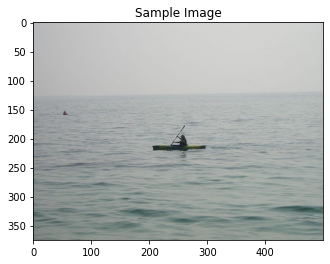

torch.Size([1, 3, 224, 224])
a man riding a surfboard on a wave in the ocean . 


In [9]:
file_name = 'boat.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)
generate_caption(input_image.reshape(1,3,224,224).to('cuda'))

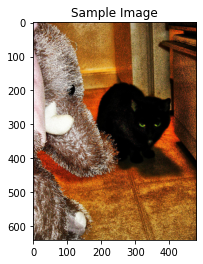

torch.Size([1, 3, 224, 224])
a cat is sitting on a couch next to a stuffed animal . 


In [62]:
file_name = 'cat.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)
generate_caption(input_image.reshape(1,3,224,224).to('cuda'))

In [63]:
import torch.nn.functional as F
from utils import visualize_cam, Normalize, print_examples
transform = transforms.Compose([
            transforms.Resize((356, 356)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
# features,image,orig_image = get_prediction()
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(orig_image)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
norm_torch_img = normalizer(torch_img)

In [22]:
encoder.resnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [28]:
from gradcam import GradCAM
from datetime import datetime
from torchvision.utils import make_grid, save_image

In [59]:
from utils import find_resnet_layer
images = []
layer_name = encoder.resnet._modules['4'][0].conv1
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

layer_name = encoder.resnet._modules['5'][0].conv1
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

layer_name = encoder.resnet._modules['6'][0].conv1
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

layer_name = encoder.resnet._modules['6'][35].conv3
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))


images = make_grid(torch.cat(images,0),nrow=3)

15_10_52


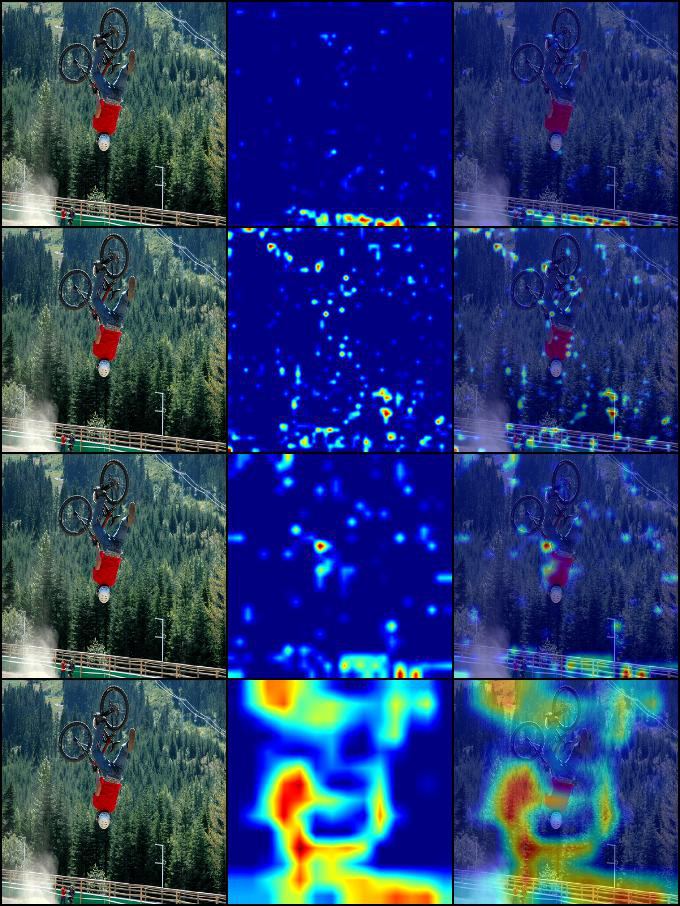

In [60]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%H_%M_%S")
print(dt_string)
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

output_name = dt_string+'_8_layers'+file_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image.open(output_path)

In [47]:
modules = list(encoder.resnet.children())

modules.pop(-3)
len(modules)

8

In [51]:
modules[5]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(

In [58]:
modules[-2][0].conv1

[autoreload of model failed: Traceback (most recent call last):
  File "C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\ACER\anaconda3\envs\deepLearning\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\ACER\anaconda3\envs\deepLearning\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
 

Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [39]:
for i in range(0,len(modules)):
    print(i)
    print(modules[i])

0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2
ReLU(inplace=True)
3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [24]:
modules[-2][0].conv1.in_channels = 512

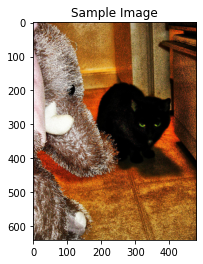

In [16]:
file_name = 'cat.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)
# generate_caption(input_image.reshape(1,3,224,224).to('cuda'))

In [27]:
import torch.nn as nn
my_encoder = nn.Sequential(*modules)
my_encoder(input_image.reshape(1,3,224,224).to('cuda'))

RuntimeError: Given groups=1, weight of size [512, 1024, 1, 1], expected input[1, 512, 28, 28] to have 1024 channels, but got 512 channels instead